#### Jennie An, Ryan Costa, Manon LeDonne, Jasmine Wong
#### DS4300 Final Project: H&M Recommendation Engine
#### 19 April 2023
#### nlp_strategy.ipynb is a recommendation engine that utilizes Tensorflow to recommend clothing items similar to each other based on product descriptions.

In [1]:
# Import Tensorflow and hub
import tensorflow as tf

import tensorflow_hub as hub

# Plotting
import matplotlib.pyplot as plt

# Other libraries
import numpy as np
import pandas as pd

# PCA and Nearest Neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


### Step 1: Connect Similar Articles to Each Other

In [2]:
# Connect to Google's Universal Sentence Encoder & load the model
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(model_url)
print("Model Loaded")

2023-04-19 13:20:05.754945: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model Loaded


In [3]:
def embed(texts):
    '''
    The embed function takes a list of texts and inserts them into the sentence encoder model
    '''
    return model(texts)

In [4]:
# Set global variables
ARTICLES = "articles.csv"

# Import Data
articles_df = pd.read_csv(ARTICLES)

# Inspect data
print(articles_df.head(10))

   article_id  product_code                  prod_name  product_type_no   
0   108775015        108775                  Strap top              253  \
1   108775044        108775                  Strap top              253   
2   108775051        108775              Strap top (1)              253   
3   110065001        110065          OP T-shirt (Idro)              306   
4   110065002        110065          OP T-shirt (Idro)              306   
5   110065011        110065          OP T-shirt (Idro)              306   
6   111565001        111565        20 den 1p Stockings              304   
7   111565003        111565        20 den 1p Stockings              302   
8   111586001        111586  Shape Up 30 den 1p Tights              273   
9   111593001        111593   Support 40 den 1p Tights              304   

  product_type_name  product_group_name  graphical_appearance_no   
0          Vest top  Garment Upper body                  1010016  \
1          Vest top  Garment Upper bod

In [5]:
# Create a df of articles and their descriptions
desc_df = articles_df[["article_id", "detail_desc"]]
desc_df.head(10)

,article_id,detail_desc
0,108775015,Jersey top with narrow shoulder straps.
1,108775044,Jersey top with narrow shoulder straps.
2,108775051,Jersey top with narrow shoulder straps.
3,110065001,"Microfibre T-shirt bra with underwired, moulde..."
4,110065002,"Microfibre T-shirt bra with underwired, moulde..."
5,110065011,"Microfibre T-shirt bra with underwired, moulde..."
6,111565001,"Semi shiny nylon stockings with a wide, reinfo..."
7,111565003,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,Tights with built-in support to lift the botto...
9,111593001,"Semi shiny tights that shape the tummy, thighs..."


In [6]:
# Check for null values and drop them
desc_df.isna().sum().sum()
desc_df = desc_df.dropna()
desc_df = desc_df.reset_index()

In [7]:
# Inspect the resulting df shape
print(desc_df.shape)
print(desc_df["detail_desc"].nunique())

(105126, 3)
43404


Text(0, 0.5, 'Frequency')

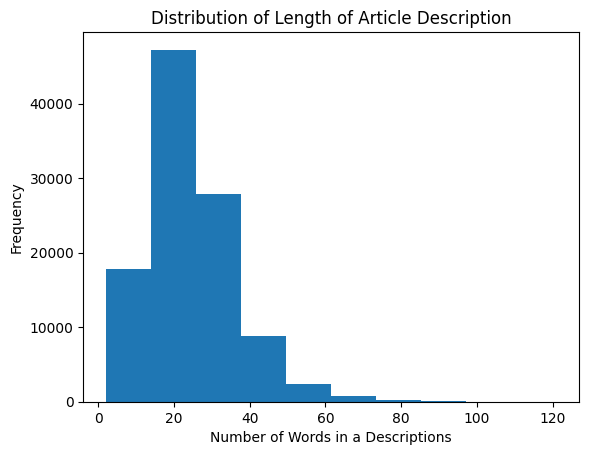

In [8]:
# Excecute EDA: Find distribution of wordcounts in product descriptions
desc_df['word_count'] = desc_df['detail_desc'].apply(lambda x : len(x.split()))
plt.hist(desc_df['word_count'])
plt.title("Distribution of Length of Article Description")
plt.xlabel("Number of Words in a Descriptions")
plt.ylabel("Frequency")

In [9]:
# Compile the descriptions into a list
descriptions = list(desc_df['detail_desc'])

In [10]:
# Embed the descriptions into high dimensional vectors
embeddings = embed(descriptions)

In [11]:
# Conduct Principle Componenet Analysis to be able to plot the embeddings in 2 dimensions
pca = PCA(n_components = 2)
emb_2d = pca.fit_transform(embeddings)

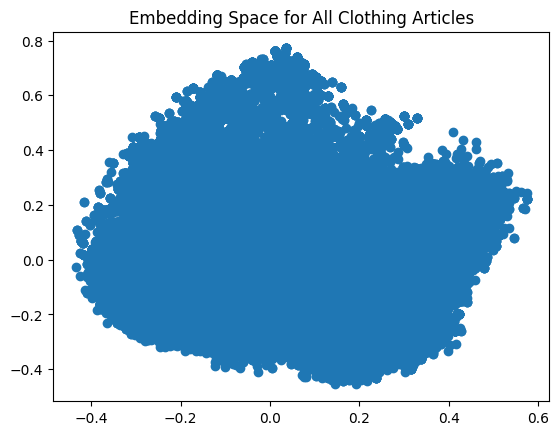

In [12]:
# Plot the Embeddings
plt.figure()
plt.title("Embedding Space for All Clothing Articles")
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.show()

In [13]:
# Set a nearest neighbor to get the most related pieces
nn = NearestNeighbors(n_neighbors=2, metric = "cosine")
nn.fit(embeddings)

NearestNeighbors(metric='cosine', n_neighbors=2)

### Step 2: Recommend a piece of clothing for a customer based on one of their past purchases

In [14]:
# Import the transactions data & create a list of unique customers
transactions = pd.read_csv("transactions_sample.csv")

# Generate a list of all of the customer ids in the sample csv
customer_ids = transactions["customer_id"].unique().tolist()

In [15]:
# Select a random customer
import random

def choose_customer_article(rand_customer):
    '''
    choose_customer_article selects a random clothing article from a given customer's past purchases

    Parameters:
        rand_customer: the customer id of a random customer in the dataset

    Returns:
        dictionary of {random customer's customer id: random article's article id} and a df of rand_customer's past purchases
    '''
    random.seed(1)

    print("The random customer is: Customer ID", rand_customer)

    # Select one of the customer's their past purchases
    purchases = transactions.loc[transactions["customer_id"] == rand_customer] 
    article = purchases.sample(n=1)["article_id"].to_string(index = False)

    return {rand_customer: article}, purchases

In [16]:
# Make dummy df that is empty
empty = pd.DataFrame()

In [17]:
def recommend(past_purchases = empty, article = descriptions):
    '''
    Reccomend generates a list of article recommendations for a customer based on an input of one of their previous purchases

    Parameters:
        past_purchases: a df of the customers past purchases to check that the recommended pieces has not been bought yet
        article: article id of the past purchase that we are generating recommendations from

    Returns:
        articles: list of product recommendations for the customer
    '''
    # Embed the list of sentences
    emb = embed([article])
    # Get indexes of nearest neighbots
    neighbors = nn.kneighbors(emb, return_distance = False)[0]
    # Get list of article id's for the suggested articles
    article_ids = desc_df['article_id'].iloc[neighbors].tolist()

    # Initialize an empty list to store the extended article information
    articles = []
    
    # For each article in list of recommended article ids
    for article in article_ids:
        if past_purchases.empty != True:
            # Check that customer has not purchased it yet
            if int(article) not in past_purchases["article_id"].values:
                # Find the extended information for them from the articles df & append to articles list
                item = articles_df.loc[articles_df['article_id'] == article]
                articles.append(item)

        # If the customer has no part purchases, return the recommendations without filtering
        else:
            item = articles_df.loc[articles_df['article_id'] == article]
            articles.append(item)

    return articles

In [18]:
def nlp_recommendation(rand_customer):
    '''
    nlp_recommendation takes in a random customer and returns a list of their tailored recommendations

    Parameters:
        rand_customer: a string of the customer ID for the customer of interest

    Returns:
        recommendations: a list of recommendations for the customer
    '''

    # Choose a random article and extract this customer's past purchases
    rand_cust_article, past_purchases = choose_customer_article(rand_customer)

    print("The random article selected is article", rand_cust_article[rand_customer])

    # Generate recommendations
    recommendations = recommend(past_purchases, rand_cust_article[rand_customer])

    return recommendations

In [19]:
# Generate a recommendation for a random customer based on their past pruchase
random.seed(60)
rand_customer = random.choice(customer_ids)
nlp_recommendation(rand_customer)

The random customer is: Customer ID fc1730a6d5cfaa12d692fd81f4ce1d5759b247383bea6571a570ccc1a467151c
The random article selected is article 399201042


[       article_id  product_code            prod_name  product_type_no   
 34637   642906001        642906  PE - FRANCES ring 2               79  \
 
       product_type_name product_group_name  graphical_appearance_no   
 34637              Ring        Accessories                  1010016  \
 
       graphical_appearance_name  colour_group_code colour_group_name  ...   
 34637                     Solid                  3            Silver  ...  \
 
           department_name index_code  index_name index_group_no   
 34637  Take Care External          A  Ladieswear              1  \
 
        index_group_name section_no    section_name garment_group_no   
 34637        Ladieswear         97  Collaborations             1001  \
 
        garment_group_name                detail_desc  
 34637             Unknown  Large silver-plated ring.  
 
 [1 rows x 25 columns],
        article_id  product_code         prod_name  product_type_no   
 47155   687999001        687999  Ring Cut & Paste   

### Run a few tests to compare to other models

In [20]:
# First test for a yellow sweater
recommend(article = "700326002")

[     article_id  product_code     prod_name  product_type_no   
 125   181448022        181448  Jenny 5-pack              302  \
 
     product_type_name product_group_name  graphical_appearance_no   
 125             Socks     Socks & Tights                  1010016  \
 
     graphical_appearance_name  colour_group_code colour_group_name  ...   
 125                     Solid                  9             Black  ...  \
 
      department_name index_code  index_name index_group_no  index_group_name   
 125               UW          D     Divided              2           Divided  \
 
     section_no    section_name garment_group_no  garment_group_name   
 125         51  Divided Basics             1017   Under-, Nightwear  \
 
           detail_desc  
 125  Fine-knit socks.  
 
 [1 rows x 25 columns],
      article_id  product_code     prod_name  product_type_no   
 126   181448102        181448  Jenny 5-pack              302  \
 
     product_type_name product_group_name  graphical_a

In [21]:
# Second test for a Dress
recommend(article = "761577002")

[     article_id  product_code           prod_name  product_type_no   
 373   233091003        233091  Magic Gloves 2pack               71  \
 
     product_type_name product_group_name  graphical_appearance_no   
 373            Gloves        Accessories                  1010016  \
 
     graphical_appearance_name  colour_group_code colour_group_name  ...   
 373                     Solid                  9             Black  ...  \
 
      department_name index_code  index_name index_group_no  index_group_name   
 373     Knit & Woven          D     Divided              2           Divided  \
 
     section_no         section_name garment_group_no  garment_group_name   
 373         52  Divided Accessories             1019         Accessories  \
 
            detail_desc  
 373  Fine-knit gloves.  
 
 [1 rows x 25 columns],
      article_id  product_code           prod_name  product_type_no   
 374   233091015        233091  Magic Gloves 2pack               71  \
 
     product_type_